## Hardware Testbed and Large-scale Testbed Co-simulation

## Co-Simulation

In [1]:
# --- imports ---

import os
import subprocess

import time
import logging
logger = logging.getLogger(__name__)

import csv
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import andes
andes.config_logger(30)
print(andes.__version__)

%matplotlib inline

# --- set logging level ---
# logger.setLevel(logging.WARNING)
from core_io import data_read, data_write, io_config, cs_stat, cs_config, cs_col

1.7.7


In [2]:

is_test = False
rflie = 'datar.txt'
wfile = 'dataw.txt'
if is_test:
    rflie = 't' + rflie

# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')
path_ltb = os.path.join(path_proj, 'core_ltb.py')
filer = os.path.join(path_data, rflie)
filew = os.path.join(path_data, wfile)
path_ehtb = os.path.join(path_data, 'ehtb.py')
path_out = os.path.join(path_proj, 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')

### Co-Simulation

In [3]:

# --- Pre Process ---
# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')
path_ltb = os.path.join(path_proj, 'core_ltb.py')
filer = os.path.join(path_data, rflie)
filew = os.path.join(path_data, wfile)
path_ehtb = os.path.join(path_data, 'ehtb.py')
path_out = os.path.join(os.path.abspath('..'), 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')

# --- set case ---
ss = andes.load(case3,
                no_output=True,
                default_config=False,
                setup=False)

#  --- HTB variables ---
pq_htb = 'PQ_86'  # load represents for HTB
bus_htb = ss.PQ.get(idx=pq_htb, src='bus', attr='v')  # get bus index of HTB
bus_slack = ss.Slack.bus.v[0]  # get bus index of slack bus

# add Bus Freq. Measurement to HTB bus
ss.add('BusFreq', {'idx': 'BusFreq_HTB',
                   'name': 'BusFreq_HTB',
                   'bus': bus_htb,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})
ss.add('BusFreq', {'idx': 'BusFreq_Slack',
                   'name': 'BusFreq_Slack',
                   'bus': bus_slack,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})

ss.add('Output', {'model': 'GENCLS',
                   'varname': 'omega'})
ss.add('Output', {'model': 'GENROU',
                   'varname': 'omega'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'a'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'v'})

ss.setup()

msg_ltb = f"LTB case: {ss.files.case.split('/')[-1]}.\n"
msg_htb = f"HTB is set to LTB load {pq_htb}, connected to LTB bus {bus_htb}."
logger.warning(msg_ltb + msg_htb)
logger.warning("LTB setup completed.")

rows = np.ceil((cs_config['t_total'] - cs_config['ti']) / cs_config['t_step'])
cs_num = -1 * np.ones((int(rows), len(cs_col)))

const_freq = 2 * np.pi * ss.config.freq  # constant to calculate bus angle
flag_init = True  # Flag to indicate the very first iteration
flag_tc0 = True  # Flag to record `tc0`

flag_datar = False  # Flag to indicate if data read is successful
flag_dataw = False  # Flag to indicate if data write is successful

flag_base = True  # Flag t0 update counter base

# --- system initial conditions ---

a0 = ss.Bus.get(idx=bus_slack, src='a', attr='v')  # initial slack bus angle
p0 = ss.PQ.get(idx=pq_htb, src='p0', attr='v')  # initial HTB bus active power
q0 = ss.PQ.get(idx=pq_htb, src='q0', attr='v')  # initial HTB bus reactive power

ss.TDS.config.no_tqdm = 1  # turn off tqdm progress bar
ss.TDS.config.criteria = 0  # turn off stability criteria

# set constant power load
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()  # solve power flow
ss.TDS.config.tf = cs_config['ti']
ss.TDS.run()

logger.warning("Start HTB.")
t0_htb = time.time()

rows = cs_config['t_total'] / cs_config['t_step'] - 50
k0 = 0

while (cs_stat['kr'] != 11):
    # --- repeat reading data until kr==11 ---
    [cs_stat['kr'], cs_stat['p'], cs_stat['q']], txtc, flag_datar = data_read(file=filer, config=io_config)
    kr0 = cs_stat['kr']
    k0 = cs_stat['k']
    # --- reset io_config default values ---
    [io_config['p_df'], io_config['q_df']] = [cs_stat['p'], cs_stat['q']]
flag_init = False  # Turn off init_flag after first iteration
logger.warning("Co-sim initialized.")
while cs_stat['k'] < rows:
    if flag_tc0:
        tc0 = time.time()  # record clock time
        flag_tc0 = False
    # --- data read ---
    # NOTE: repeat reading data until counter update
    iter_read = 0
    k0 = cs_stat['k']
    # NOTE: repeat reading data until read counter `cs_stat['kr]` update
    t0_htb = time.time()
    while (cs_stat['kr'] != kr0 + 1) & (iter_read <= cs_config['itermax_io']):
        [cs_stat['kr'], cs_stat['p'], cs_stat['q']], txtc, flag_datar = data_read(file=filer, config=io_config)
        [io_config['p_df'], io_config['q_df']] = [cs_stat['p'], cs_stat['q']]
        iter_read += 1
    if iter_read > cs_config['itermax_io']:
        cs_stat['p'], cs_stat['q'] = io_config['p_df'], io_config['q_df']
    tc1 = time.time()  # record clock time
    # NOTE: update cumulative counter if read counter update successfully
    kr0 = cs_stat['kr']
    k0 = cs_stat['k']
    cs_stat['k'] += 1
    # --- LTB sim ---
    # --- info ---
    if np.mod(cs_stat['k'], 100) == 0:
        msg = "Counter update: k=%d" % cs_stat['k']
        logger.warning(msg)
    # --- send data to HTB ---
    # NOTE: Make sure `BusFreq` is connected to the load bus
    f_send = ss.BusFreq.get(idx='BusFreq_HTB', src='f', attr='v')  # p.u.
    v_bus = ss.Bus.get(idx=bus_htb, src='v', attr='v')  # RMS, p.u.
    dataw = [v_bus, f_send]  # LTB: voltage, angle
    data_write(dataw=dataw, file=filew, config=io_config)
    tc2 = time.time()  # send end time
    # --- LTB simulation ---
    p_inj = cs_config['load_switch'] * cs_stat['p']
    q_inj = cs_config['load_switch'] * cs_stat['q']
    # a) set PQ data in LTB
    ss.PQ.set(value=p_inj + p0, idx=pq_htb, src='Ppf', attr='v')
    ss.PQ.set(value=q_inj + q0, idx=pq_htb, src='Qpf', attr='v')
    # b) TDS
    ss.TDS.config.tf += cs_config['t_step']
    ss.TDS.run()
    tc3 = time.time()  # record clock time
    # NOTE: tf_htb is the end time of last round
    if tc3 - t0_htb > 2 * cs_config['t_step']:
        cs_stat['iter_fail'] += 1
    cs_stat['tr'] = tc1 - t0_htb  # read time
    cs_stat['tw'] = tc2 - tc1  # write time
    cs_stat['tsim'] = tc3 - tc2  # write time
    # update HTB time
#     t0_htb += cs_config['t_step']
    cs_stat['iter_total'] += 1
    flag_base = True
    #  --- record data ---
    for col in cs_col:
        cs_num[cs_stat['k']-1, cs_col.index(col)] = cs_stat[col]
    # update counter base
    if flag_base & (cs_stat['kr'] == 199):
        cs_stat['kr'] = 10
        kr0 = 10
        flag_base = False
        msg = "LTB: Counter base Updated"
#         logger.warning(msg)

msg_end = "Co-sim finished."
logger.warning(msg_end)

# --- save data ---
cosim_out = pd.DataFrame(data=cs_num, columns=cs_col)
outfile_name = f'/{datetime.datetime.now().strftime("%m%d%y_%H%M")}_output.csv'
csv_out = path_out + outfile_name

ss_outname = f'/{datetime.datetime.now().strftime("%m%d%y_%H%M")}_ltb.csv'
ss.TDS.load_plotter()
ss.TDS.plt.export_csv(path=path_out+ss_outname)

cosim_out['tall'] = cosim_out['tw'] + cosim_out['tr']+ cosim_out['tsim']
cosim_out.to_csv(csv_out, index=False, header=True)
logger.warning(f"Co-sim data saved to folder: {path_out}")


LTB case: C:\CEPD00615\hlcosim\ltb\case\npcc_htb.xlsx.
HTB is set to LTB load PQ_86, connected to LTB bus 131.
LTB setup completed.
GENCLS (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENCLS_3  | 0.990  | 1    
 GENCLS_4  | 0.926  | 1    
 GENCLS_16 | 0.933  | 1    


Start HTB.
Co-sim initialized.
Counter update: k=100
Counter update: k=200
Counter update: k=300
Counter update: k=400
Counter update: k=500
Counter update: k=600
Counter update: k=700
Counter update: k=800
Counter update: k=900
Counter update: k=1000
Counter update: k=1100
Counter update: k=1200
Counter update: k=1300
Counter update: k=1400
Counter update: k=1500
Counter update: k=1600
Counter update: k=1700
Counter update: k=1800
Counter update: k=1900
Counter update: k=2000
Counter update: k=2100
Counter update: k=2200
Counter update: k=2300
Counter update: k=2400
Counter update: k=2500
Counter update: k=2600
Counter update: k=2700
Counter update: k=2800
Counter updat

In [4]:
cs_stat

{'iter_total': 3950,
 'iter_fail': 0,
 'kr': 63,
 'k': 3950,
 'a_ltb': 0,
 'p': 0.10000000000000009,
 'q': 0.0,
 'tw': 0.0,
 'tr': 0.00099945068359375,
 'tsim': 0.05996561050415039}

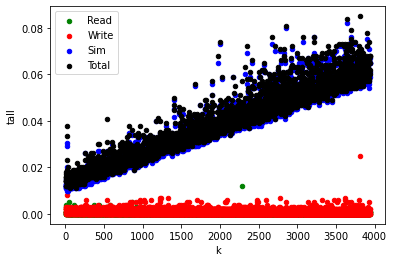

In [5]:
fig_t, ax_t = plt.subplots()
cosim_out = cosim_out.iloc[0:-40]
cosim_out.plot.scatter(x='k', y='tw', color='green', fig=fig_t, ax=ax_t)
cosim_out.plot.scatter(x='k', y='tr', color='red', fig=fig_t, ax=ax_t)
cosim_out.plot.scatter(x='k', y='tsim', color='blue', fig=fig_t, ax=ax_t)
cosim_out.plot.scatter(x='k', y='tall', color='black', fig=fig_t, ax=ax_t)
ax_t.legend(['Read', 'Write', 'Sim', 'Total'])

<AxesSubplot:xlabel='k'>

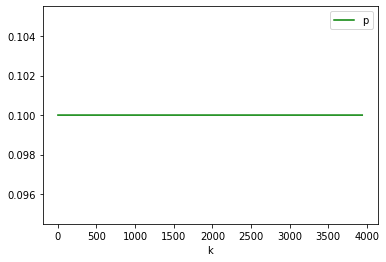

In [6]:
cosim_out.plot(x='k', y='p', color='green')

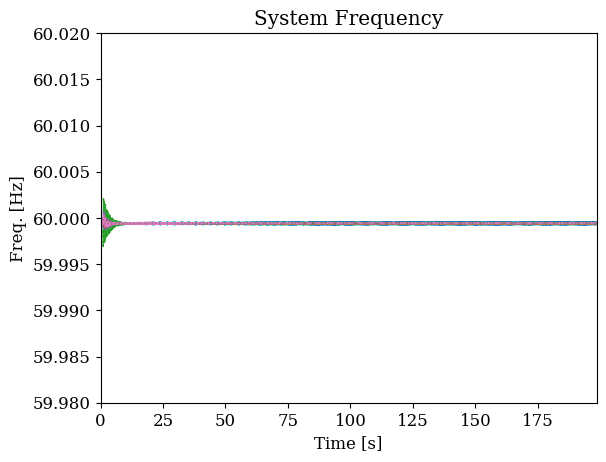

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'System Frequency'}, xlabel='Time [s]', ylabel='Freq. [Hz]'>)

In [7]:
ss.TDS.plt.plot([ss.GENROU.omega, ss.GENCLS.omega],
                ytimes=ss.config.freq,
                ylabel='Freq. [Hz]',
                ymin=59.98, ymax=60.02,
                title='System Frequency',)